https://www.streambatch.io/knowledge/esa-worldcereal-global-crop-monitoring-at-field-scale

# ESA WorldCereal - Global Crop Monitoring at Field-Scale

## Summary
Using the [ESA WorldCereal](https://www.esa.int/Applications/Observing_the_Earth/Introducing_World_Cereal) dataset, this tutorial demonstrates how to:
- generate any number of global maize, winter cereals and spring cereals farm point locations (longitude, latitude coordinate pairs) from the .tif classification mask files
- and how to export the locations to cloud-native ([Parquet](https://parquet.apache.org/) & [GeoParquet](https://geoparquet.org/)) and standard tabular (CSV) formats.

Parquet and GeoParquet enable maximum interoperability with data science workflows and the modern stack.

## Preconstructed Data
If you dont want to generate your own locations, you can also download the final exported location datasets at the following links:
- world_cereals_scaled_final_all.parquet (101 MB)
- world_cereals_scaled_final_all.geoparquet (100 MB)
- world_cereals_scaled_final_3m.csv (a 3M point randomly selected subset of the above tables) (379 MB)

For each farm location, the final datasets include (and thus can be filtered by) the following information:
- Crop
- Country (Admin 0)
- State (Admin 1)	
- Region (World Bank)	
- Subregion	
- Continent	
- aez_id

## About WorldCereal
The [ESA WorldCereal](https://www.esa.int/Applications/Observing_the_Earth/Introducing_World_Cereal) dataset consists of 10m resolution global crop type maps (classification masks) covering maize, winter cereals and spring cereals. For maize and winter cereals, there are 106 .tif (raster) files corresponding to the 106 Agricultural Ecological Zones (AEZs) across the globe. Spring cereals are only covered for 21 of the 106 AEZs. Find the article (Van Tricht et al., 2023, in pre-print) describing the full methodology [here](https://essd.copernicus.org/preprints/essd-2023-184/).

For this tutorial, we used the full datasets available [here](https://zenodo.org/record/7875105). To run this notebook, download the following, unzip them, and move the folders to a folder called 'data' wherever the notebook is saved:
- WorldCereal_2021_tc-maize-main_maize_classification.zip (18.2 GB)
- WorldCereal_2021_tc-wintercereals_wintercereals_classification.zip (18.5 GB)
- WorldCereal_2021_tc-springcereals_springcereals_classification.zip (7.0 GB)
- WorldCereal_AEZ.geojson (762 KB)

The ESA WorldCereal dataset may also be accessed (for smaller, user-specified regions only) through the [OpenEO API](https://github.com/Open-EO/openeo-community-examples/blob/main/python/WorldCereal/WorldCereal.ipynb).

#### Why is having farm point locations a game changer?
Data science workflows, and indeed the entire modern data stack (including cloud infrastructure more generally and cloud data warehouses), have been optimized for both storing and processing columnar data formats (tabular data, such as timeseries information). Having farm point locations (as opposed to being stored in scientific raster data like the .tif format these masks come in) means that we can begin to take advantage of the advancements that have been made in these areas, bringing digital agronomy one step closer to the modern stack. 

# Import Libraries

In [3]:
# Required for location generation
import os
import geopandas as gpd
import rasterio
import numpy as np
import pandas as pd

# Required for location tagging
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cf
import cartopy.io.shapereader as shpreader
from shapely.geometry import Point, Polygon

# Define Functions

The .tif raster files are very large so we first define a function to read them in in chunks to avoid any memory-related issues.

In [4]:
def read_raster_in_chunks(dataset):
    for ji, window in dataset.block_windows(1):
        band_window = dataset.read(window=window, indexes=1)
        yield band_window, ji

# Demo vs Full Run

In demo-mode, running the tutorial notebook will generate Maize farm locations for 3 of the 106 AEZs (covering Mexico, Guatemala, El Salvador, Honduras, and North-Western Nicaragua). It is expected to take <10min to run for these AEZs. If you wish to run the code on different AEZs covering different regions than specified, modify the aez_id_list (but note that it may take >10min). 

In full-mode, running the tutorial notebook will generate farm locations for Maize, Winter Cereals, and Spring Cereals for all 106 AEZs (where available). *Note running the notebook in full-mode can take numerous hours (10-15+).

In [5]:
# Specify if the run is a demo
demo_mode = True  # Change to False for a full run

In [6]:
# Read the geojson containing the aez footprints as polygons
aez = gpd.read_file('data/WorldCereal_AEZ.geojson')

# List of all aez_ids
aez_ids = aez['aez_id'].unique()

# Create a list to hold dataframes
dfs = []

# Define the directories and crop_types based on whether it is a demo run or not
if demo_mode:
    directories = ['data/WorldCereal_2021_tc-springcereals_springcereals_classification']
    crop_types = {'data/WorldCereal_2021_tc-springcereals_springcereals_classification': 'Spring Cereals'}
else:
    directories = [
        'data/WorldCereal_2021_tc-maize-main_maize_classification',
        'data/WorldCereal_2021_tc-wintercereals_wintercereals_classification',
        'data/WorldCereal_2021_tc-springcereals_springcereals_classification'
    ]
    crop_types = {
        'data/WorldCereal_2021_tc-maize-main_maize_classification': 'Maize',
        'data/WorldCereal_2021_tc-wintercereals_wintercereals_classification': 'Winter Cereals',
        'data/WorldCereal_2021_tc-springcereals_springcereals_classification': 'Spring Cereals'
    }

# Determine the aez_id list for processing
aez_id_list = [15081,19093,33117] if demo_mode else aez_ids

# Iterate over all directories
for directory in directories:

    print(f"Processing: {crop_types[directory]} ({directory})")

    # Iterate over all unique aez_ids
    for aez_id in aez_id_list:

        print(f"Processing aez_id: {aez_id}")

        # Get list of all .tif files in the directory
        all_files = os.listdir(directory)

        for file in all_files:
                    # Check if the file starts with the aez_id and ends with .tif
                    if file.startswith(str(aez_id)) and file.endswith('.tif'):
                        # Full path to the file
                        filename = os.path.join(directory, file)

                        # Open the raster
                        dataset = rasterio.open(filename)

                        # Read the band in chunks
                        chunks = read_raster_in_chunks(dataset)

                        # Process one chunk at a time
                        for i, (band_chunk, ji) in enumerate(chunks):

                            # Find the indices where band_chunk has values of 100
                            indices = np.where(band_chunk == 100)
                        
                            # Determine the total number of classified pixels
                            total_classified = len(indices[0])

                            # Determine the proportion of classified pixels to sample
                            proportion = 0.0001  # For example, to sample 0.01% of classified pixels

                            # Determine the number of samples to draw
                            num_samples = int(np.round(total_classified * proportion))

                            # Skip this chunk if there are fewer than 1 pixels with a value of 100
                            if num_samples < 1:
                                continue

                            # Randomly sample num_samples points from the classified indices 
                            sample_indices = np.random.choice(total_classified, size=num_samples, replace=False)

                            # Get the row and column indices
                            rows = indices[0][sample_indices] + ji[0]*band_chunk.shape[0]
                            cols = indices[1][sample_indices] + ji[1]*band_chunk.shape[1]

                            # Transform the row and column indices to the original CRS (EPSG:4326)
                            x_coords, y_coords = dataset.xy(rows, cols)

                            data = {'lon': x_coords, 'lat': y_coords, 'aez_id': aez_id, 'crop': crop_types[directory]}

                            df = pd.DataFrame(data)

                            # Append the df to dfs
                            dfs.append(df)

# Concatenate all the dataframes in dfs
final_df = pd.concat(dfs, ignore_index=True)

Processing: Spring Cereals (data/WorldCereal_2021_tc-springcereals_springcereals_classification)
Processing aez_id: 15081
Processing aez_id: 19093
Processing aez_id: 33117


# Tag Administrative Regions

We're now going to use the Natural Earth Features (https://www.naturalearthdata.com/features/) country and state-level administrative datasets to tag the farm locations generated above. For simplicity, we will access the datasets through cartopy, but the full list of datasets may also be accessed here: https://github.com/nvkelso/natural-earth-vector.

*Note: you can use any boundary file that may be relevant to your use case to tag the locations. 

In [7]:
# shpfilename = the path to your shapefile
ne_level_0 = shpreader.natural_earth(resolution='10m', category='cultural', name='admin_0_countries')
ne_level_1 = shpreader.natural_earth(resolution='10m', category='cultural', name='admin_1_states_provinces')

# Read the shapefile using GeoPandas
countries_gdf = gpd.read_file(ne_level_0)
states_gdf = gpd.read_file(ne_level_1)

/Users/Francisco/opt/anaconda3/envs/pythonDS/lib/python3.11/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_cultural/ne_10m_admin_0_countries.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/Users/Francisco/opt/anaconda3/envs/pythonDS/lib/python3.11/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_cultural/ne_10m_admin_1_states_provinces.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


#### Countries (Admin Level 0), Regions, Subregions, Contintents

In [8]:
# Convert the df DataFrame to a GeoDataFrame
geometry = [Point(xy) for xy in zip(final_df['lon'], final_df['lat'])]
merged_geo = gpd.GeoDataFrame(final_df, geometry=geometry)

# Set the CRS of the merged_geo GeoDataFrame to EPSG:4326 (WGS 84)
merged_geo.crs = "EPSG:4326"

# Transform the CRS of merged_geo to match the CRS of county_boundaries
merged_geo = merged_geo.to_crs(countries_gdf.crs)

# Perform a spatial join
joined = gpd.sjoin(merged_geo, countries_gdf, predicate='within', how='left')

# Remove duplicate index after spatial join
joined = joined.loc[~joined.index.duplicated(keep='first')]

# # Copy the required columns back to the df DataFrame
final_df['Country (Admin 0)'] = joined['ADMIN']
final_df['Region (World Bank)'] = joined['REGION_WB']
final_df['Subregion'] = joined['SUBREGION']
final_df['Continent'] = joined['CONTINENT']

#### States (Admin Level 1)

In [9]:
# Convert the df DataFrame to a GeoDataFrame
geometry = [Point(xy) for xy in zip(final_df['lon'], final_df['lat'])]
merged_geo = gpd.GeoDataFrame(final_df, geometry=geometry)

# Set the CRS of the merged_geo GeoDataFrame to EPSG:4326 (WGS 84)
merged_geo.crs = "EPSG:4326"

# Transform the CRS of merged_geo to match the CRS of county_boundaries
merged_geo = merged_geo.to_crs(states_gdf.crs)

# Perform a spatial join
joined = gpd.sjoin(merged_geo, states_gdf, predicate='within', how='left')

# Remove duplicate index after spatial join
joined = joined.loc[~joined.index.duplicated(keep='first')]

# # Copy the required columns back to the df DataFrame
final_df['State (Admin 1)'] = joined['name']

# Remove duplicated points caused by AEZ overlap

As a result of the point generation methodology, there will be double the number of locations in regions where the Agricultural Ecological Zones overlap. We can take care of this easily by randomly filtering half of the points that fall in these regions (in reality we used 40% as the results looked better). 

In [26]:
# Convert the DataFrame to a GeoDataFrame
geometry = [Point(xy) for xy in zip(final_df['lon'], final_df['lat'])]
geo_df = gpd.GeoDataFrame(final_df, geometry=geometry)

# Set CRS for geo_df to match aez
geo_df.set_crs(epsg=4326, inplace=True)

# Read the geojson to a GeoDataFrame
aez = gpd.read_file('data/WorldCereal_AEZ.geojson')

# Create a spatial join between the points and the polygons to determine which points fall in overlapping polygons
overlaps = gpd.sjoin(geo_df, aez, how='inner', predicate='within')

# Group points by 'aez_id' and find the groups that have more than one polygon (overlapping areas)
overlapping_points = overlaps.groupby(['lon', 'lat']).filter(lambda x: len(x) > 1)

# Sample 40% of the rows (for some reason 40% works better than 50%)
overlapping_points_sampled = overlapping_points.sample(frac=0.40)

# If you want to reset index
overlapping_points_sampled.reset_index(drop=True, inplace=True)

# Create a key in both dataframes for merging
overlapping_points_sampled['key'] = overlapping_points_sampled['lon'].astype(str) + '-' + overlapping_points_sampled['lat'].astype(str)
final_df['key'] = final_df['lon'].astype(str) + '-' + final_df['lat'].astype(str)

# Perform a left merge to identify rows in final_df that are not present in overlapping_points_sampled
merged_df = pd.merge(final_df, overlapping_points_sampled[['key']], on='key', how='left', indicator=True)

# Filter rows that are only present in final_df (not present in overlapping_points_sampled)
final_df_filtered = merged_df[merged_df['_merge'] == 'left_only']

# Remove the key and _merge columns
final_df_filtered = final_df_filtered.drop(columns=['key', '_merge'])

final_df_filtered = final_df_filtered[final_df_filtered['aez_id'] != 2008]
final_df_filtered=final_df_filtered.reset_index()
final_df_filtered=final_df_filtered.drop(columns='index')

In [28]:
final_df

,lon,lat,aez_id,crop,geometry,Country (Admin 0),Region (World Bank),Subregion,Continent,State (Admin 1),key
0,-119.175583,35.145408,33117,Spring Cereals,POINT (-119.17558 35.14541),United States of America,North America,Northern America,North America,California,-119.17558330543912-35.14540828971452
1,-114.651330,34.956575,33117,Spring Cereals,POINT (-114.65133 34.95657),United States of America,North America,Northern America,North America,California,-114.65133029196365-34.95657477017712
2,-114.677497,33.503657,33117,Spring Cereals,POINT (-114.67750 33.50366),United States of America,North America,Northern America,North America,California,-114.67749697605919-33.503656670823894
3,-114.604580,33.534990,33117,Spring Cereals,POINT (-114.60458 33.53499),United States of America,North America,Northern America,North America,California,-114.60458026082478-33.53499003505428
4,-111.906578,33.260406,33117,Spring Cereals,POINT (-111.90658 33.26041),United States of America,North America,Northern America,North America,Arizona,-111.90657846376298-33.260406430960856
...,...,...,...,...,...,...,...,...,...,...,...
1925,-97.532652,18.841892,33117,Spring Cereals,POINT (-97.53265 18.84189),Mexico,Latin America & Caribbean,Central America,North America,Puebla,-97.53265222303534-18.84189221322097
1926,-97.490152,18.756809,33117,Spring Cereals,POINT (-97.49015 18.75681),Mexico,Latin America & Caribbean,Central America,North America,Puebla,-97.4901521947273-18.756808795988984
1927,-97.489486,18.749809,33117,Spring Cereals,POINT (-97.48949 18.74981),Mexico,Latin America & Caribbean,Central America,North America,Puebla,-97.48948552761658-18.74980878908645
1928,-86.119728,12.840470,33117,Spring Cereals,POINT (-86.11973 12.84047),Nicaragua,Latin America & Caribbean,Central America,North America,Matagalpa,-86.11972795454639-12.840469628700081


# Filter Out Known Problem Areas

In [12]:
problem_areas = [{"type":"Polygon","coordinates":[[[-91.41645262581089,54.84799699573268],[-91.41645262581089,54.40865331122363],[-88.50502911906254,54.40865331122363],[-88.50502911906254,54.84799699573268],[-91.41645262581089,54.84799699573268]]]},
{"type":"Polygon","coordinates":[[[-79.38191682251309,54.670532808406904],[-79.38191682251309,54.49882652204195],[-78.23689388953464,54.49882652204195],[-78.23689388953464,54.670532808406904],[-79.38191682251309,54.670532808406904]]]},
{"type":"Polygon","coordinates":[[[-113.05802983596446,14.41831703002663],[-113.05802983596446,10.575178190653537],[-111.7893818359246,10.575178190653537],[-111.7893818359246,14.41831703002663],[-113.05802983596446,14.41831703002663]]]},
{"type":"Polygon","coordinates":[[[-63.27121541570759,4.99991096599964],[-63.27121541570759,4.644926639828461],[-61.255111317670405,4.644926639828461],[-61.255111317670405,4.99991096599964],[-63.27121541570759,4.99991096599964]]]},
{"type":"Polygon","coordinates":[[[-55.22828268903994,4.8967529432137775],[-55.22828268903994,4.6843848378761095],[-54.05519296541787,4.6843848378761095],[-54.05519296541787,4.8967529432137775],[-55.22828268903994,4.8967529432137775]]]},
{"type":"Polygon","coordinates":[[[14.734498345968422,16.466073725257086],[14.734498345968422,16.153617663042045],[16.160038004412126,16.153617663042045],[16.160038004412126,16.466073725257086],[14.734498345968422,16.466073725257086]]]},
{"type":"Polygon","coordinates":[[[10.047319891400315,25.881031010977033],[13.892714535598202,25.881031010977033],[13.892714535598202,25.90303910294598],[10.047319891400315,25.90303910294598],[10.047319891400315,25.881031010977033]]]},
{"type":"Polygon","coordinates":[[[25.107042348440654,16.476830796786135],[25.107042348440654,16.16039393217118],[29.22283561548171,16.16039393217118],[29.22283561548171,16.476830796786135],[25.107042348440654,16.476830796786135]]]},
{"type":"Polygon","coordinates":[[[-4.002359251877331,3.201968162153812],[-4.002359251877331,0.9911969039241092],[-3.0296770780975124,0.9911969039241092],[-3.0296770780975124,3.201968162153812],[-4.002359251877331,3.201968162153812]]]},
{"type":"Polygon","coordinates":[[[31.16567670234616,6.839946329744742],[31.16567670234616,6.597515189353094],[32.33595020343498,6.597515189353094],[32.33595020343498,6.839946329744742],[31.16567670234616,6.839946329744742]]]},
{"type":"Polygon","coordinates":[[[40.89590023680697,19.097407436266657],[38.494290401310344,19.097407436266657],[38.494290401310344,19.368491481354894],[40.89590023680697,19.368491481354894],[40.89590023680697,19.097407436266657]]]},
{"type":"Polygon","coordinates":[[[32.93416524828737,31.775717980082778],[32.93416524828737,31.40013168824121],[33.136596368919584,31.40013168824121],[33.136596368919584,31.775717980082778],[32.93416524828737,31.775717980082778]]]},
{"type":"Polygon","coordinates":[[[85.98995391688953,39.165321115823744],[85.98995391688953,39.04406645824486],[91.67097903032186,39.04406645824486],[91.67097903032186,39.165321115823744],[85.98995391688953,39.165321115823744]]]},
{"type":"Polygon","coordinates":[[[57.034595092248644,59.83370125144946],[57.034595092248644,59.73558220090944],[58.68328068555554,59.73558220090944],[58.68328068555554,59.83370125144946],[57.034595092248644,59.83370125144946]]]},
{"type":"Polygon","coordinates":[[[16.901144386723477,37.11315362858931],[16.901144386723477,36.347826299638434],[17.259848338498678,36.347826299638434],[17.259848338498678,37.11315362858931],[16.901144386723477,37.11315362858931]]]},
{"type":"Polygon","coordinates":[[[-11.74332466793228,45.28783163983705],[-11.74332466793228,44.66939402069726],[-11.240611651323693,44.66939402069726],[-11.240611651323693,45.28783163983705],[-11.74332466793228,45.28783163983705]]]},
{"type":"Polygon","coordinates":[[[112.63187216718639,-34.99965785029128],[112.63187216718639,-35.981599748501544],[113.46733203935531,-35.981599748501544],[113.46733203935531,-34.99965785029128],[112.63187216718639,-34.99965785029128]]]},
{"type":"Polygon","coordinates":[[[73.69232615055289,15.376372183850695],[73.66955721328479,15.376372183850695],[73.66955721328479,15.715384183383437],[73.69232615055289,15.715384183383437],[73.69232615055289,15.376372183850695]]]},
{"type":"Polygon","coordinates":[[[73.58561245202628,15.226695719650461],[73.58561245202628,14.196424425273419],[73.80691834331373,14.196424425273419],[73.80691834331373,15.226695719650461],[73.58561245202628,15.226695719650461]]]},
{"type":"Polygon","coordinates":[[[121.77275981253091,53.3317057483241],[121.77275981253091,53.29519565546789],[124.27015494296099,53.29519565546789],[124.27015494296099,53.3317057483241],[121.77275981253091,53.3317057483241]]]},
{"type":"Polygon","coordinates":[[[100.19693890959938,40.29125609428906],[100.19693890959938,40.21829955885904],[104.88706903084042,40.21829955885904],[104.88706903084042,40.29125609428906],[100.19693890959938,40.29125609428906]]]}]

In [29]:
# Create the list of Polygon objects from the geojson data
problem_polygons = [Polygon(area['coordinates'][0]) for area in problem_areas]

# Function to check if a point is in any of the problem areas
def is_in_problem_area(row):
    point = Point(row['lon'], row['lat'])
    return any(polygon.contains(point) for polygon in problem_polygons)

# Apply the function to each row in the dataframe
final_df_filtered['is_in_problem_area'] = final_df_filtered.apply(is_in_problem_area, axis=1)

# Filter the dataframe to remove points in problem areas
final_df_filtered = final_df_filtered[final_df_filtered['is_in_problem_area'] == False]

# You can drop the 'is_in_problem_area' column afterwards if you wish
final_df_filtered = final_df_filtered.drop(columns=['is_in_problem_area'])

final_df_filtered = final_df_filtered.reset_index()
final_df_filtered = final_df_filtered.drop(columns=['index'])

In [30]:
final_df_filtered

,lon,lat,aez_id,crop,geometry,Country (Admin 0),Region (World Bank),Subregion,Continent,State (Admin 1)
0,-114.651330,34.956575,33117,Spring Cereals,POINT (-114.65133 34.95657),United States of America,North America,Northern America,North America,California
1,-114.677497,33.503657,33117,Spring Cereals,POINT (-114.67750 33.50366),United States of America,North America,Northern America,North America,California
2,-114.604580,33.534990,33117,Spring Cereals,POINT (-114.60458 33.53499),United States of America,North America,Northern America,North America,California
3,-111.906578,33.260406,33117,Spring Cereals,POINT (-111.90658 33.26041),United States of America,North America,Northern America,North America,Arizona
4,-112.417412,33.215656,33117,Spring Cereals,POINT (-112.41741 33.21566),United States of America,North America,Northern America,North America,Arizona
...,...,...,...,...,...,...,...,...,...,...
1923,-97.532652,18.841892,33117,Spring Cereals,POINT (-97.53265 18.84189),Mexico,Latin America & Caribbean,Central America,North America,Puebla
1924,-97.490152,18.756809,33117,Spring Cereals,POINT (-97.49015 18.75681),Mexico,Latin America & Caribbean,Central America,North America,Puebla
1925,-97.489486,18.749809,33117,Spring Cereals,POINT (-97.48949 18.74981),Mexico,Latin America & Caribbean,Central America,North America,Puebla
1926,-86.119728,12.840470,33117,Spring Cereals,POINT (-86.11973 12.84047),Nicaragua,Latin America & Caribbean,Central America,North America,Matagalpa


# Final Processing

Reorder columns & capitalize column label text.

In [31]:
final_df_filtered = final_df_filtered[['lon', 'lat', 'crop', 'Country (Admin 0)', 'State (Admin 1)', 'Region (World Bank)', 'Subregion', 'Continent', 'aez_id']]
final_df_filtered = final_df_filtered.rename(columns={'crop': 'Crop'})

,lon,lat,Crop,Country (Admin 0),State (Admin 1),Region (World Bank),Subregion,Continent,aez_id
0,-114.651330,34.956575,Spring Cereals,United States of America,California,North America,Northern America,North America,33117
1,-114.677497,33.503657,Spring Cereals,United States of America,California,North America,Northern America,North America,33117
2,-114.604580,33.534990,Spring Cereals,United States of America,California,North America,Northern America,North America,33117
3,-111.906578,33.260406,Spring Cereals,United States of America,Arizona,North America,Northern America,North America,33117
4,-112.417412,33.215656,Spring Cereals,United States of America,Arizona,North America,Northern America,North America,33117
...,...,...,...,...,...,...,...,...,...
1923,-97.532652,18.841892,Spring Cereals,Mexico,Puebla,Latin America & Caribbean,Central America,North America,33117
1924,-97.490152,18.756809,Spring Cereals,Mexico,Puebla,Latin America & Caribbean,Central America,North America,33117
1925,-97.489486,18.749809,Spring Cereals,Mexico,Puebla,Latin America & Caribbean,Central America,North America,33117
1926,-86.119728,12.840470,Spring Cereals,Nicaragua,Matagalpa,Latin America & Caribbean,Central America,North America,33117


# Saving Final Locations Dataset

#### Parquet ([.parquet](https://parquet.apache.org/)) 

In [17]:
final_df_filtered.to_parquet('world_cereals_scaled_final_all_demo.parquet') 

#### GeoParquet ([.geoparquet](https://geoparquet.org/)) 

In [18]:
# Creating the geometry column from the coordinates
geometry = [Point(xy) for xy in zip(final_df_filtered['lon'], final_df_filtered['lat'])]

# Creating a GeoDataFrame by adding the geometry column to the original DataFrame
final_gdf = gpd.GeoDataFrame(final_df_filtered, geometry=geometry)

final_gdf.drop(columns=['lon','lat']).to_parquet('world_cereals_scaled_final_all_demo.geoparquet')

#### CSV (.csv)

In [35]:
final_df_filtered.to_csv('world_cereals_scaled_final_all_demo.csv') 
# final_df_filtered.sample(n=3000000, random_state=1).to_csv('world_cereals_scaled_final_3M.csv')

<Axes: >

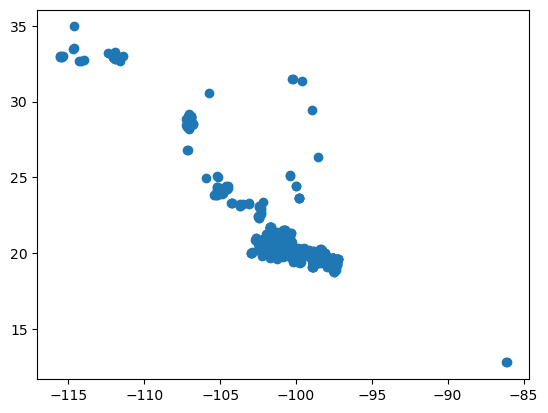

In [36]:
final_gdf.plot()